In [1]:
import numpy as np
import cv2
from scipy.optimize import minimize, Bounds
import os
import matplotlib.pyplot as plt
import pandas as pd

def crop_circle_with_mask_float(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])
    Y, X = np.ogrid[:h, :w]
    mask = (X - center[0])**2 + (Y - center[1])**2 <= radius**2
    return img * mask  # retain float values

def preprocess(image, radius):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # <-- convert to grayscale

    if radius == 37:
        gray_image = cv2.resize(image, (80, 80), interpolation=cv2.INTER_AREA)
    else:
        gray_image = cv2.resize(image, (100, 100), interpolation=cv2.INTER_AREA)

    Gauss_image = cv2.GaussianBlur(gray_image, (3, 3), 1).astype(np.float32)
    image_norm = Gauss_image / Gauss_image.max()
    return image_norm

def compute_G2_map(img):
    """
    Compute G² map from a grayscale image using gradient filters.
    """
    img = img.astype(np.float32)

    # Define kernels
    kx = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]], dtype=np.float32)
    ky = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]], dtype=np.float32)
    kxy1 = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=np.float32)
    kxy2 = np.array([[0, 0, -1], [0, 0, 0], [1, 0, 0]], dtype=np.float32)

    gx = cv2.filter2D(img, -1, kx, borderType=cv2.BORDER_REFLECT)
    gy = cv2.filter2D(img, -1, ky, borderType=cv2.BORDER_REFLECT)
    gxy1 = cv2.filter2D(img, -1, kxy1, borderType=cv2.BORDER_REFLECT)
    gxy2 = cv2.filter2D(img, -1, kxy2, borderType=cv2.BORDER_REFLECT)

    G2_map = gx**2 + gy**2 + 0.5 * (gxy1**2 + gxy2**2)
    return G2_map

def get_disk_img(pdata, img):
       
    img = img[250:1200, :]  # crop top/bottom

    entry = pdata.copy()
    x = int(np.around(entry['xi'][0]))
    y = int(np.around(entry['yi'][0]))
    r = int(entry['ri'][0])

    h, w = img.shape[:2]
    y1, y2 = max(0, y - r), min(h, y + r)
    x1, x2 = max(0, x - r), min(w, x + r)
    img_crop = img[y1:y2, x1:x2]

    if img_crop.shape[0] == 0 or img_crop.shape[1] == 0:
        raise ValueError("Cropped region is empty. Check particle location or radius.")

    gray_img = preprocess(img_crop, int(entry['ri'][0]))

    # Compute G² map
    G2_map = compute_G2_map(gray_img)
    gray_img = crop_circle_with_mask_float(gray_img)
    # Apply circular mask
    G2_cropped = crop_circle_with_mask_float(G2_map)

    return gray_img, G2_cropped    


def circular_roi_mask_from_pdata(pdata, idx, d, img_shape, roi_radius=None):
    """
    Create a circular ROI mask centered along the line from particle i to j,
    at distance d from i, with optional roi_radius (defaults to ri of i).
    Returns a boolean mask of shape img_shape.
    """

    xi, yi = pdata.iloc[idx]['xi'], pdata.iloc[idx]['yi']
    xj, yj = pdata.iloc[idx]['xj'], pdata.iloc[idx]['yj']

    if roi_radius is None:
        roi_radius = pdata.iloc[idx]['ri']/3
    dx, dy = xj - xi, yj - yi
    norm = np.hypot(dx, dy)
    if norm == 0:
        raise ValueError("Particles i and j are at the same position.")
    ux, uy = dx / norm, dy / norm
    cx, cy = img_shape[1] / 2 + d * ux, img_shape[0] / 2 + d * uy
    Y, X = np.ogrid[:img_shape[0], :img_shape[1]]
    mask = (X - cx)**2 + (Y - cy)**2 <= roi_radius**2
    return mask

def append_contactG2_sum_to_pdata(pdata, G2Img, roi_distance=None, roi_radius=None):
    """
    For each contact in pdata, compute the sum of G2Img within a circular ROI
    centered along the line from i to j, at distance d from i.
    Appends a new column 'contactG2_sum' to pdata.
    - roi_distance: if None, uses pdata['ri'] for each contact.
    - roi_radius: if None, uses pdata['ri'] for each contact.
    """
    contact_g2_means = []
    for idx, row in pdata.iterrows():

        # Distance from i to ROI center
        d = roi_distance if roi_distance is not None else row['ri']*2/3
        mask = circular_roi_mask_from_pdata(pdata, idx, d, G2Img.shape, roi_radius=roi_radius)
        contact_g2_means.append(float(np.mean(G2Img * mask)))

    pdata['contactG2_mean'] = contact_g2_means
    return pdata

def append_ij_angle_to_pdata(pdata):
    dx = pdata['xj'].to_numpy() - pdata['xi'].to_numpy()
    dy = pdata['yj'].to_numpy() - pdata['yi'].to_numpy()
    pdata = pdata.copy()
    pdata['beta'] = np.arctan2(dy, dx)
    return pdata

def forceBalance(force, alpha, beta, verbose =True):

    # Adjust beta
    beta = -beta + np.pi / 2
    z = len(beta)
    
    if z < 2:
        f = force
    elif z == 2:
        # Calculate dbeta and set f and alpha
        dbeta = (beta[0] - beta[1]) / 2
        f = np.zeros(2)
        f[0] = force[0]
        alpha[0] = np.arccos(np.sin(dbeta))
        
        if alpha[0] > np.pi / 2:
            alpha[0] = np.arccos(np.sin(-dbeta))
        
        # Handle complex alpha values
        if np.isreal(alpha[0]) == 0:
            alpha[0] = 0
            print('Warning1 : ForceBalance encountered a complex value in alpha where none was expected. Setting to 0 instead.')
        
        f[1] = f[0]
        alpha[1] = -alpha[0]
                
    else:
        f = np.zeros(z)
        for k in range(z):
            sum1 = 0
            sum2 = 0
            
            # Compute sums for force components
            for i in range(z):
                if i != k:
                    sum1 += force[i] * np.sin(alpha[i] + beta[i] - beta[k])
                    sum2 += force[i] * np.cos(alpha[i] + beta[i] - beta[k])
            
            # Calculate the force
            f_k = np.sqrt(sum1**2 + sum2**2)
            
            # BEGIN SANITY CHECKS
            if not np.isfinite(f_k) or f_k < 0:
                if verbose:
                    print(f'Warning2 : f_k invalid for k={k}, f_k={f_k}. Setting to 0.')
                f_k = 0.0
            f[k] = f_k
        
        a = np.zeros(z)
        for k in range(z):
            sum3 = 0
            for i in range(z):
                if i != k:
                    sum3 += f[i] * np.sin(alpha[i])
            
            ratio = -sum3 / f[k]
            
            # Calculate angle a
            if abs(ratio) <1 :
                a[k] = np.arcsin(ratio)
            
            else: 
                a[k] = 0
                print(f'f[k]={f[k]}, sum3 = {sum3}, ratio = {-sum3 / f[k]}')
            
            # BEGIN SANITY CHECKS
            if np.isnan(a[k]):
                a[k] = 0
                print('Warning: ForceBalance encountered a NAN value in a(k) where none was expected. Setting to 0 instead.')
            
            if np.isreal(a[k]) == 0:
                a[k] = 0
                print('Warning: ForceBalance encountered a complex value in a(k) where none was expected. Setting to 0 instead.')
            # END SANITY CHECKS
        
        # Set final alpha values
        alpha = a
    
    return alpha, f

def forceBalance_minimize(force, alpha, beta):

    force = np.asarray(force)
    alpha = np.asarray(alpha)
    beta = np.asarray(beta)

    z = len(beta)

    if z == 2:
        # Calculate dbeta and set f and alpha
        dbeta = (beta[0] - beta[1]) / 2
        f_out = np.zeros(2)
        f_out[0] = force[0]
        alpha[0] = np.arccos(np.sin(dbeta))
        
        if alpha[0] > np.pi / 2:
            alpha[0] = np.arccos(np.sin(-dbeta))
        
        # Handle complex alpha values
        if np.isreal(alpha[0]) == 0:
            alpha[0] = 0
            print('Warning: ForceBalance encountered a complex value in alpha where none was expected. Setting to 0 instead.')
        
        f_out[1] = f_out[0]
        alpha[1] = -alpha[0]
        a_out = alpha

    else:
        assert force.shape == (z,)
        assert alpha.shape == (z,)

        def net_force(params):
            f = params[:z]
            a = params[z:]
            fx = np.sum(f * np.cos(a + beta))
            fy = np.sum(f * np.sin(a + beta))
            return fx**2 + fy**2

        # Bounds
        lb_f = np.zeros(z)             # force >= 0
        ub_f = np.full(z, np.inf)      # no upper bound on force
        lb_a = np.zeros(z) 
        ub_a = np.full(z, np.inf)
        bounds = Bounds(np.concatenate([lb_f, lb_a]),
                        np.concatenate([ub_f, ub_a]))

        x0 = np.concatenate([force, alpha])

        res = minimize(net_force, x0, method='L-BFGS-B', bounds=bounds)

        if not res.success:
            print("Warning: Force balance optimization did not converge.")

        f_out = res.x[:z]
        a_out = res.x[z:]

    return a_out, f_out


In [2]:
import torch
import cv2
import torch.nn.functional as F


def StressSolve_residue_torch(xxi, xxj, f, alpha, beta, fsigma, rm, power, eps = 1e-10):
    """
    Vectorized batch version of StressSolve_residue including residual stress tensor.
    
    xxi, xxj: [HW] tensors, particle coordinates
    f, alpha, beta: [z] tensors, contact info
    fsigma, rm, power: scalars
    eps: small number to avoid division by zero
    """
    device = xxi.device
    z = f.shape[0]
    HW = xxi.shape[0]

    # Adjust beta
    beta_adj = -beta + torch.pi / 2  # [z]

    pioverfsigma = torch.pi / fsigma
    twooverpi = 2 / torch.pi

    # Reshape for broadcasting
    xxi_exp = xxi.unsqueeze(0)   # [1, HW]
    xxj_exp = xxj.unsqueeze(0)   # [1, HW]
    f_exp = f.unsqueeze(1)       # [z, 1]
    alpha_exp = alpha.unsqueeze(1)  # [z, 1]
    beta_exp = beta_adj.unsqueeze(1) # [z, 1]

    # Chord angles
    b = beta_exp + torch.pi / 2
    a = alpha_exp
    b2 = torch.where(a < 0, b + (torch.pi + 2 * a), b - (torch.pi - 2 * a))

    # Chord points
    x1 = rm * torch.sin(b)
    y1 = rm * torch.cos(b)
    x2 = rm * torch.sin(b2)
    y2 = rm * torch.cos(b2)

    ch0 = x2 - x1
    ch1 = y2 - y1
    chn = torch.sqrt(ch0 ** 2 + ch1 ** 2 + eps)
    ch0 = ch0 / chn
    ch1 = ch1 / chn

    # r vector
    r10 = xxi_exp - x1         # [z, HW]
    r11 = -xxj_exp - y1        # [z, HW]
    r1n = torch.sqrt(r10**2 + r11**2 + eps)

    # Angles and s1
    costh1 = (r10 * ch0 + r11 * ch1) / r1n
    costh1 = torch.clamp(costh1, -1 + eps, 1 - eps)
    signth = torch.where(r11 * ch0 > r10 * ch1, 1.0, -1.0)
    th1 = signth * torch.acos(costh1)

    s1 = -(f_exp * twooverpi) / r1n * costh1
    th = th1 - beta_exp - alpha_exp

    # Stress components from contacts
    sigmaxx = torch.sum(s1 * torch.sin(th)**2, dim=0)  # [HW]
    sigmayy = torch.sum(s1 * torch.cos(th)**2, dim=0)
    sigmaxy = torch.sum(0.5 * s1 * torch.sin(2*th), dim=0)

    # Residual stress tensor
    R = torch.sqrt(xxi**2 + xxj**2 + eps)  # [HW]
    K_RESIDUAL = -fsigma / (torch.pi * power * rm**power) * torch.arcsin(torch.tensor(1., device=device)**0.5)

    sigma_r_res = K_RESIDUAL * (rm**power - R**power)
    sigma_theta_res = K_RESIDUAL * (rm**power - (power+1) * R**power)

    Theta = torch.atan2(xxi, xxj)
    sigma_xx_res = sigma_r_res * torch.cos(Theta)**2 + sigma_theta_res * torch.sin(Theta)**2
    sigma_yy_res = sigma_r_res * torch.sin(Theta)**2 + sigma_theta_res * torch.cos(Theta)**2
    tau_xy_res = (sigma_r_res - sigma_theta_res) * torch.sin(Theta) * torch.cos(Theta)

    # Total stress
    sigmaxx_tot = sigmaxx + sigma_xx_res
    sigmayy_tot = sigmayy + sigma_yy_res
    sigmaxy_tot = sigmaxy + tau_xy_res

    # Final residue
    aa = torch.sqrt((sigmaxx_tot - sigmayy_tot)**2 + 4 * sigmaxy_tot**2)
    result = torch.sin(pioverfsigma * aa)**2
    result = torch.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    return result  # [HW], one residue per particle

def synth_img_pytorch_residue(fsigma, rm, px, f, alpha, beta, device='cuda'): 
    x = torch.linspace(-rm, rm, px, device=device) 
    xxi, xxj = torch.meshgrid(x, x, indexing='ij') 
    xxi = xxi.reshape(-1) 
    xxj = xxj.reshape(-1) 
    r2 = xxi**2 + xxj**2 
    mask = r2 <= rm**2 
    xxi_in = xxi[mask] 
    xxj_in = xxj[mask] 
    intensity = StressSolve_residue_torch(xxi_in, xxj_in, f, alpha, beta, fsigma, rm, power = 10) 
    img = torch.zeros(px * px, device=device) 
    img[mask] = intensity 
    return img.reshape(px, px)

def gaussian_kernel(kernel_size=3, sigma=1.0, device='cuda'):
    # 建立 1D Gaussian kernel
    x = torch.arange(kernel_size, dtype=torch.float32, device=device) - (kernel_size - 1) / 2
    gauss = torch.exp(-x**2 / (2 * sigma**2))
    gauss = gauss / gauss.sum()
    # 2D kernel = 外積
    kernel2d = gauss[:, None] @ gauss[None, :]
    return kernel2d

def smooth_image(img, kernel_size=3, sigma=1.0):
    """
    img: [H, W] tensor, single channel
    output: [H, W] tensor,平滑後影像
    """
    device = img.device
    kernel = gaussian_kernel(kernel_size, sigma, device=device)
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # [1,1,kH,kW]

    img = img.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    smoothed = F.conv2d(img, kernel, padding=kernel_size//2)
    return smoothed.squeeze(0).squeeze(0)


def fit_disk_residue(photo_img, z, fsigma, rm, px, f0, alpha0, beta, lr, n_iter=1000, device='cuda', tol=5e-4, patience=300):
    """
    Fit force magnitudes (f0) and angles (alpha0) to match the photoelastic image.
    No tanh/softplus: f0 and alpha0 are optimized directly.
    """
    # Ensure requires_grad
    f0 = f0.clone().detach().to(device).requires_grad_(True)
    alpha0 = alpha0.clone().detach().to(device).requires_grad_(True)
    beta = beta.to(photo_img.device)

    optimizer = torch.optim.Adam([f0, alpha0], lr=lr)

    prev_loss = None
    patience_counter = 0
    loss_history = []

    # Print initial loss before any step
    #with torch.no_grad():
    #    synth_init = synth_img_pytorch_residue(fsigma, rm, px, f0, alpha0, beta)
    #    init_loss = ((smooth_image(synth_init) - photo_img) ** 2).mean().item()
    #    print(f"Initial loss (before fitting): {init_loss:.6f}")

    for i in range(n_iter):
            optimizer.zero_grad()

            f0_pos = torch.abs(f0) #flip sign if any force is negative
            synth = synth_img_pytorch_residue(fsigma, rm, px, f0_pos, alpha0, beta)
            loss = ((smooth_image(synth) - photo_img) ** 2).mean()

            if torch.isnan(synth).any():
                print("Found NaN in synth image")
            if torch.isnan(loss) or torch.isinf(loss):
                print("Loss exploded")
                break

            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            loss_history.append(current_loss)

            # --------------------------
            # Early stopping (existing logic)
            # --------------------------
            if prev_loss is not None:
                if prev_loss - current_loss < tol:
                    patience_counter += 1
                else:
                    patience_counter = 0
                if patience_counter >= patience:
                    break

            prev_loss = current_loss


    return f0.detach().cpu().numpy(), alpha0.detach().cpu().numpy(), loss.detach(), loss_history

Load bond pkl file that contains neighbor information

In [3]:

experiment_name = 'TPE_20251217A02_N=265x2_e-4rps_1cycle_TwoPulse_e-1fps_LooseStart'

image_folder = os.path.join(r'N:\PROJ_TPE', experiment_name)
traj_filename = os.path.join(r'M:\Archive\Proj_TPE\Disk_traj_files', f'{experiment_name}.pkl')
bond_filename = os.path.join(r'M:\Archive\Proj_TPE\Contact_bond_files', f'CONTACT_BOND_{experiment_name}.pkl')

F_bond = pd.read_pickle(bond_filename)
F_traj = pd.read_pickle(traj_filename)


### Starts fitting 

both pre and post fittting force balancing are turned off

In [4]:
import sys
fsigma = 225
plot_every = 0 # Once this open(plot_every = 1), plot figure of balls
verbose = 0

frame_data_out = []

F_bond = append_ij_angle_to_pdata(F_bond)

#for frame in sorted(F_bond['frame'].unique()):
for frame in range(100,151):   
    sys.stdout.write(f"\rProcessing frame: {frame}")
    sys.stdout.flush() 
    
    image_path = os.path.join(image_folder, 'Ib_'+str(frame)+'.png')
    img = cv2.imread(image_path)

    frame_force = F_traj[F_traj.frame==frame]
    frame_data = F_bond[F_bond['frame'] == frame]
    
    for particle_id, pdata in frame_data.groupby('i'):
        #print(particle_id)
        z = len(pdata) #CONTACT NUMBER 
        pdata = pdata.reset_index(drop=True)
        
        ########################## If i is singular, skip ############################
        if z == 1:
            continue
        ######################### Begin inversion if z>1 ############################
        else:
             #give beta column to pdata
            GrayImg, G2Img  = get_disk_img(pdata, img)  # total force of a ball
            pdata_force = frame_force[frame_force.particle==particle_id].predicted_tot_force.iloc[0]
            pdata = append_contactG2_sum_to_pdata(pdata, G2Img)

            pdata_out = pdata.copy() 
                    
            rm = pdata.iloc[0]['ri']/37*6/1000 # rm is radius meter, value of radius
            img_size = GrayImg.shape[0]
        
            ############################ Initial force guesses ################################
            alphas = np.zeros(z, dtype=float)  # Initial angles, guess = 0
            betas = pdata['beta'].to_numpy().copy()   #call beta from bond file data
            forces = np.zeros(z, dtype=float)
                        
            for k in range(z):
                forces[k] =  pdata_force * pdata['contactG2_mean'].iloc[k] / pdata['contactG2_mean'].sum()              
                            
            #alphas, forces = forceBalance(forces.copy(), alphas.copy(), betas) # Apply force balance

            ############################# Set initial guesses to pytorch #######################################

            f0_gpu = torch.tensor(forces.tolist(), dtype=torch.float32, device='cuda')  # Force magnitude
            alpha0_gpu = torch.tensor(alphas.tolist(), dtype=torch.float32, device='cuda')  # Force angles
            betas_gpu = torch.tensor(betas.tolist(), dtype=torch.float32, device='cuda')  # Force angles
            GrayImg = torch.tensor(GrayImg, dtype=torch.float32, device='cuda')

            guess_im = synth_img_pytorch_residue(fsigma, rm, img_size, f0_gpu, alpha0_gpu, betas_gpu, device='cuda')
            
            ############################ Start fitting #########################################            
            res = fit_disk_residue(GrayImg, z, fsigma, rm, img_size, f0_gpu, alpha0_gpu, betas_gpu, tol=1e-3, patience=20, lr=2e-2, n_iter=1000)
            f_fit, alpha_fit, fitted_loss, loss_hist = res

            #alpha_balanced, f_balanced = forceBalance_minimize(f_fit.copy(), alpha_fit.copy(), betas_gpu.cpu().numpy())  # Reapply force balance after fitting

            ####################### Plot results if desired ###########################
            if verbose:
                print('Fitted Loss:', fitted_loss.cpu().numpy())
                print(f"Fitted forces: {f_fit}")
                print(f"Fitted alphas: {alpha_fit}")

            if plot_every and fitted_loss.cpu().numpy()> 0:
                fit_im = synth_img_pytorch_residue(
                    fsigma, rm, img_size,
                    torch.tensor(f_fit, dtype=torch.float32, device='cuda'),
                    torch.tensor(alpha_fit, dtype=torch.float32, device='cuda'),
                    betas_gpu, device='cuda'
                )

                plt.figure(figsize = (6,2))
                plt.subplot(1, 3, 1)
                plt.imshow(GrayImg.cpu().numpy(), cmap='gray', vmax = 1)
                plt.title(f"id = {particle_id} \n exp", fontsize=10)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(smooth_image(guess_im, kernel_size=3, sigma=1.0).cpu().numpy(), cmap='gray', vmax=1)
                plt.title("guess", fontsize=10)
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(smooth_image(fit_im, kernel_size=3, sigma=1.0).cpu().numpy(), cmap='gray', vmax=1)
                plt.title("fit", fontsize=10)
                plt.axis('off')
                plt.show()
            #################### Append particle results to frame data #############

            pdata_out['force'] = f_fit
            pdata_out['alpha'] = alpha_fit
            pdata_out['fitLoss'] = fitted_loss.cpu().numpy()

        frame_data_out.append(pdata_out)

F_bond_out = pd.concat(frame_data_out, ignore_index=True)



Processing frame: 150

<Axes: >

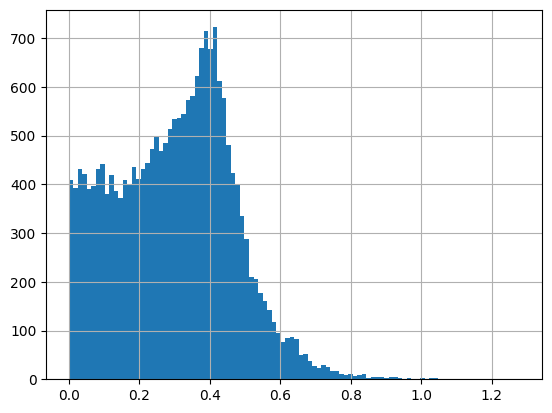

In [5]:
np.abs(F_bond_out.alpha).hist(bins = 100)

### Calculate ij/ji force difference for validation

Total ij/ji pairs found: 18728

Force statistics:
Mean absolute force difference: 0.1963 N

Alpha statistics:
Mean absolute alpha difference: 0.1701 rad (9.75°)
Pairs with opposite alpha (within 0.1 rad of π): 0 (0.0%)


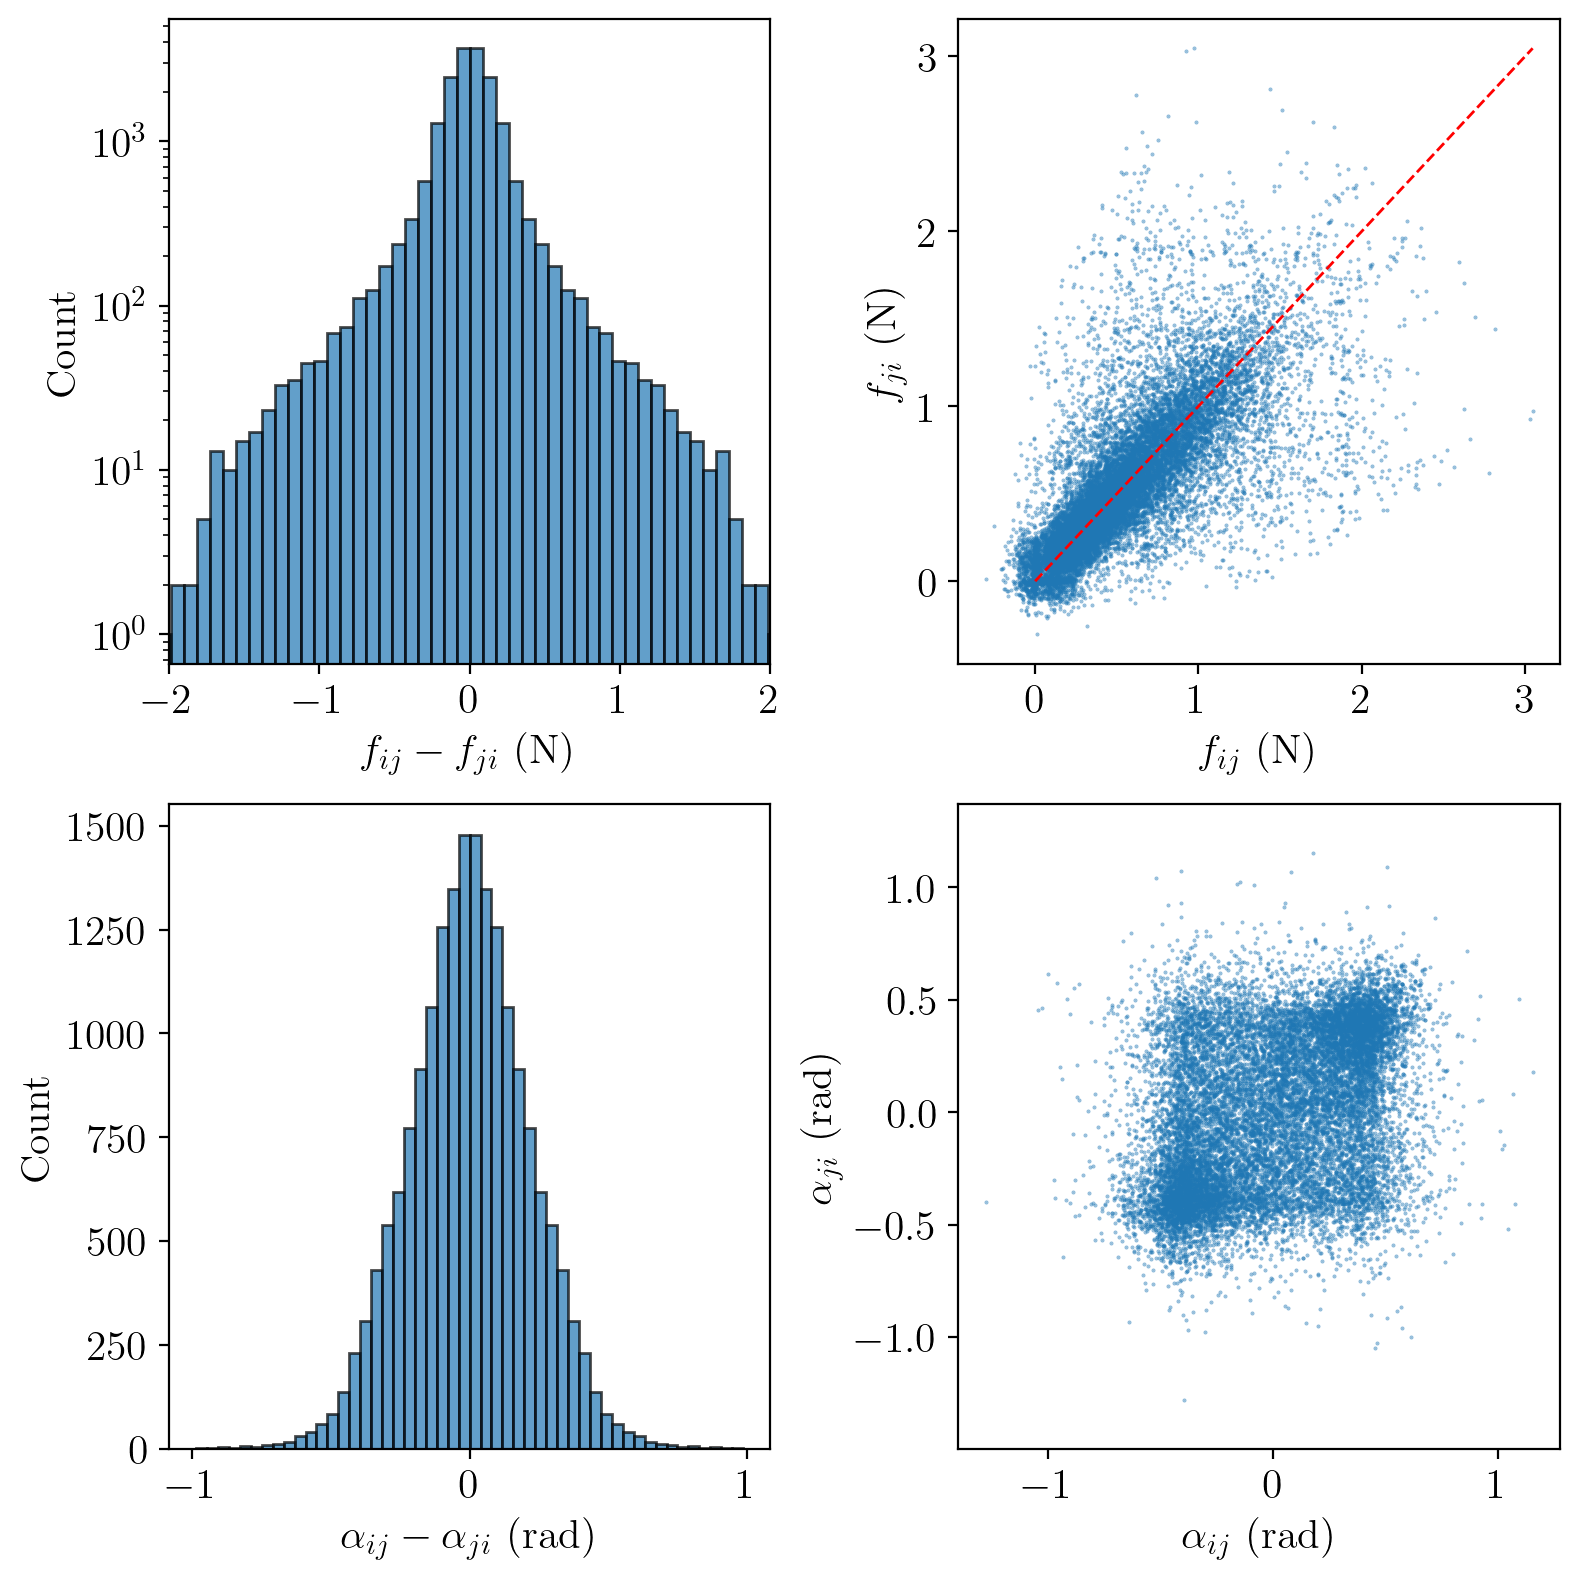

In [9]:
# Create a copy with swapped i and j to find reciprocal contacts
F_swap = F_bond_out[['frame', 'i', 'j', 'force', 'alpha', 'fitLoss']].copy()
F_swap.columns = ['frame', 'j', 'i', 'force_ji', 'alpha_ji', 'fitLoss_ji']

# Merge to get both ij and ji forces in one row
F_compare = F_bond_out.merge(F_swap, on=['frame', 'i', 'j'], how='inner')

# Compute force differences
F_compare['force_diff'] = F_compare['force'] - F_compare['force_ji']
F_compare['force_ratio'] = F_compare['force'] / (F_compare['force_ji'] + 1e-10)

# Compute alpha differences (accounting for periodicity)
F_compare['alpha_diff'] = abs(F_compare['alpha']) - abs(F_compare['alpha_ji'])
# Normalize angular difference to [-pi, pi]
F_compare['alpha_diff_norm'] = np.arctan2(
    np.sin(F_compare['alpha_diff']), 
    np.cos(F_compare['alpha_diff'])
)

# Check if alphas are opposite (should differ by ~π for action-reaction pairs)
F_compare['alpha_opposite'] = np.abs(np.abs(F_compare['alpha_diff_norm']) - np.pi) < 0.1

print(f"Total ij/ji pairs found: {len(F_compare)}")
print(f"\nForce statistics:")
print(f"Mean absolute force difference: {F_compare['force_diff'].abs().mean():.4f} N")
print(f"\nAlpha statistics:")
print(f"Mean absolute alpha difference: {F_compare['alpha_diff_norm'].abs().mean():.4f} rad ({np.degrees(F_compare['alpha_diff_norm'].abs().mean()):.2f}°)")
print(f"Pairs with opposite alpha (within 0.1 rad of π): {F_compare['alpha_opposite'].sum()} ({100*F_compare['alpha_opposite'].mean():.1f}%)")

# Find your Times New Roman font file path
times_new_roman_path = r"C:\Windows\Fonts\times.ttf"
from matplotlib import font_manager
times_new_roman_font = font_manager.FontProperties(fname=times_new_roman_path)
plt.rcParams['font.family'] = times_new_roman_font.get_name()
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# Plot histograms and scatter plots
fig = plt.figure(figsize=(8, 8))

# Force difference histogram
plt.subplot(2, 2, 1)
plt.hist(F_compare['force_diff'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel(r'$f_{ij} - f_{ji}$ (N)')
plt.ylabel('Count')
plt.xlim(-2,2)
plt.yscale('log')

# Force reciprocity scatter
plt.subplot(2, 2, 2)
plt.scatter(F_compare['force'], F_compare['force_ji'], s=0.2, alpha=0.5)
plt.plot([0, F_compare['force'].max()], [0, F_compare['force'].max()], 'r--', lw=1)
plt.xlabel(r'$f_{ij}$ (N)')
plt.ylabel(r'$f_{ji}$ (N)')


# Alpha difference histogram
plt.subplot(2, 2, 3)
plt.hist(F_compare['alpha_diff_norm'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel(r'$\alpha_{ij} - \alpha_{ji}$ (rad)')
plt.ylabel('Count')
#plt.yscale('log')

# Alpha reciprocity scatter
plt.subplot(2, 2, 4)
plt.scatter(F_compare['alpha'], F_compare['alpha_ji'], s=0.2, alpha=0.5)
plt.xlabel(r'$\alpha_{ij}$ (rad)')
plt.ylabel(r'$\alpha_{ji}$ (rad)')
plt.axis('equal')

plt.tight_layout()
plt.show()



### Check all ij/ji pairs, make all f and alpha equal to the one with smaller fitLoss

In [13]:
# For these pairs, correct the force with higher fitLoss by using the value from lower fitLoss counterpart
F_bond_corrected = F_bond_out.copy()

F_bond_corrected['force'] = np.abs(F_bond_corrected['force']) # Ensure forces are non-negative

for idx, row in F_compare.iterrows():
    frame = row['frame']
    i = row['i']
    j = row['j']
    
    # Compare fitLoss values
    if row['fitLoss'] > row['fitLoss_ji']:
        # Correct ij contact force using ji force (ji has lower fitLoss)
        mask = (F_bond_corrected['frame'] == frame) & \
               (F_bond_corrected['i'] == i) & \
               (F_bond_corrected['j'] == j)
        F_bond_corrected.loc[mask, 'force'] = row['force_ji']
        F_bond_corrected.loc[mask, 'alpha'] = row['alpha_ji']
    else:
        # Correct ji contact force using ij force (ij has lower fitLoss)
        mask = (F_bond_corrected['frame'] == frame) & \
               (F_bond_corrected['i'] == j) & \
               (F_bond_corrected['j'] == i)
        F_bond_corrected.loc[mask, 'force'] = row['force']
        F_bond_corrected.loc[mask, 'alpha'] = row['alpha']

print(f"Total contacts remain: {len(F_bond_corrected)}")

Total contacts remain: 400441


### Check results by drawing full-field synth img from fitted resuls

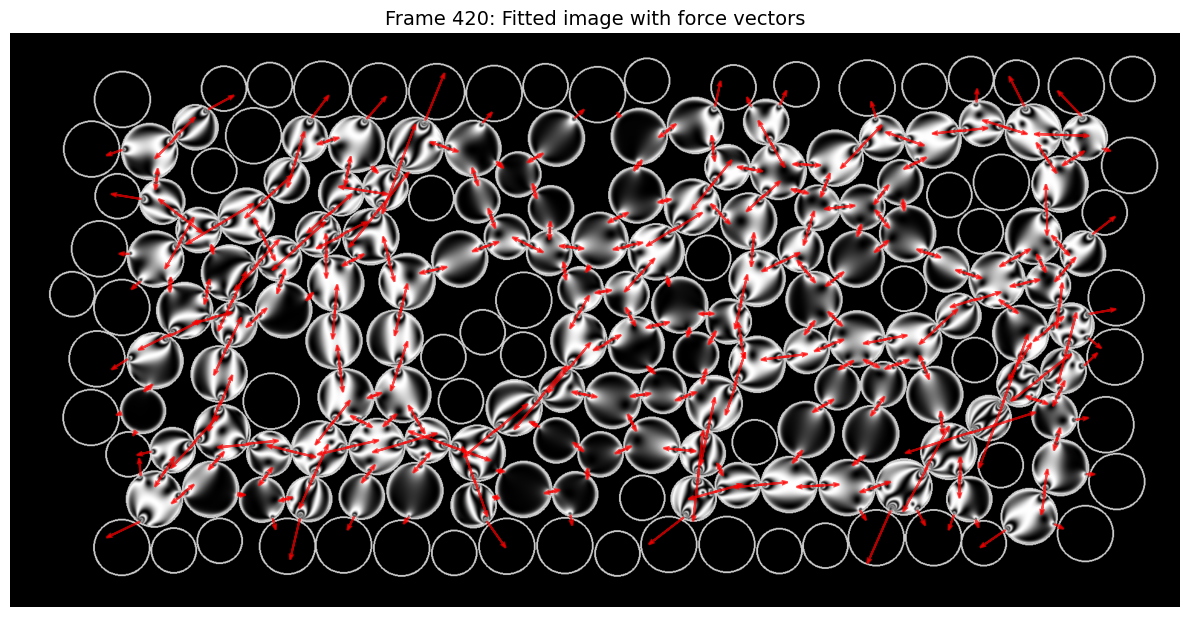

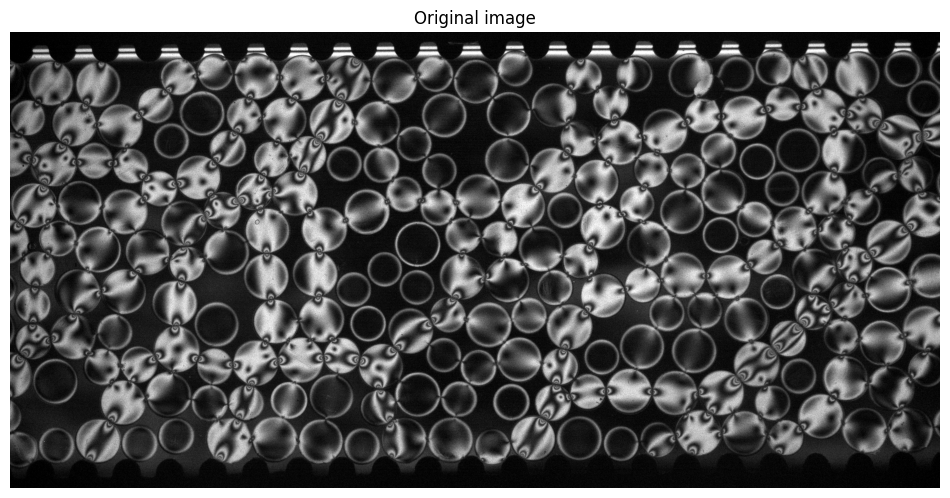

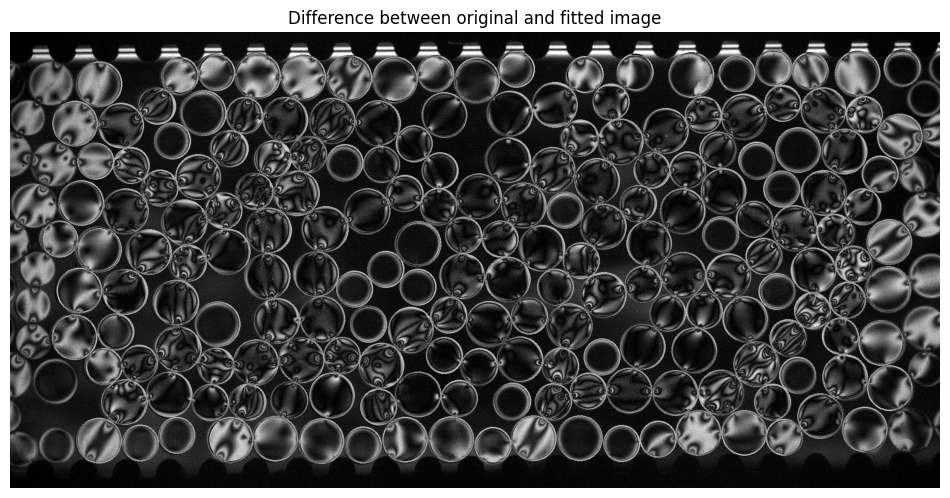

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fsigma = 225
frame = 420
f = F_bond_corrected[F_bond_corrected.frame==frame].copy()

# Load the original PE image
image_path = os.path.join(image_folder, 'Ib_'+str(frame+1)+'.png')
orig_img = cv2.imread(image_path)
orig_img = orig_img[250:1200, :]  # Apply the same crop as in get_img_and_force

output_img = np.zeros_like(orig_img, dtype=np.float32)
count_img = np.zeros_like(orig_img, dtype=np.float32)

for particle_id, entry in f.groupby('i'):
    x = int(np.around(entry['xi'].iloc[0]))
    y = int(np.around(entry['yi'].iloc[0]))
    r = int(entry['ri'].iloc[0])
    h, w = orig_img.shape[:2]
    y1, y2 = max(0, y - r), min(h, y + r)
    x1, x2 = max(0, x - r), min(w, x + r)
    crop_h, crop_w = y2 - y1, x2 - x1

    # Only plot if fit results exist and are valid
    if 'force' in entry and 'alpha' in entry:
        z = len(entry['force'])
        if z > 1:
            rm = entry['ri'].iloc[0]/40*6/1000
            px = crop_h
            f0 = torch.tensor((entry['force']).tolist(), dtype=torch.float32, device='cuda')
            alpha0 = torch.tensor(entry['alpha'].tolist(), dtype=torch.float32, device='cuda')
            beta = torch.tensor(entry['beta'].tolist(), dtype=torch.float32, device='cuda')
            fit_im = synth_img_pytorch_residue(fsigma, rm, px, f0, alpha0, beta, device='cuda')
            im_smoothed = smooth_image(fit_im, kernel_size=3, sigma=1.0)
            fit_img_np = im_smoothed.cpu().numpy()
            fit_img_cropped = crop_circle_with_mask_float(fit_img_np)
            fit_img_resized = cv2.resize(fit_img_cropped, (crop_w, crop_h), interpolation=cv2.INTER_LINEAR)
            if len(orig_img.shape) == 3 and orig_img.shape[2] == 3:
                fit_img_resized = np.stack([fit_img_resized]*3, axis=-1)
            output_img[y1:y2, x1:x2] += fit_img_resized
            count_img[y1:y2, x1:x2] += (fit_img_resized > 0).astype(np.float32)

# Plot empty circles for disks without contacts
all_particle = F_traj[F_traj.frame==frame]

for _, row in all_particle.iterrows():
    cx = int(round(float(row.x)))
    cy = int(round(float(row.y)))
    center = (cx, cy)
    radius = int(round(float(row.rpx)))

    h_out, w_out = output_img.shape[:2]
    if radius <= 0 or cx < 0 or cy < 0 or cx >= w_out or cy >= h_out:
        continue

    color = 0.8
    thickness = 2

    if output_img.ndim == 3 and output_img.shape[2] == 3:
        cv2.circle(output_img, center, radius, (color, color, color), thickness)
    else:
        cv2.circle(output_img, center, radius, color, thickness)

count_img[count_img == 0] = 1
final_img = output_img

orig_img = orig_img/orig_img.max()
diff_img = cv2.absdiff((orig_img).astype(np.float32), final_img.astype(np.float32))

# Convert grayscale to RGB for overlaying colored arrows
orig_gray = cv2.cvtColor((orig_img*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

# Plot 1: All fitted balls overlaid with force vectors
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(final_img.astype(np.float32), cmap='gray')

# Draw force vectors from contact points
arrow_scale = 50
if 1:
    for _, contact in f.iterrows():
        xi = float(contact['xi'])
        yi = float(contact['yi'])
        xj = float(contact['xj'])
        yj = float(contact['yj'])
        ri = float(contact['ri'])
        
        force_mag = float(contact['force'])
        alpha = float(contact['alpha'])
        beta = float(contact['beta'])
        
        # Calculate contact point
        dx = xj - xi
        dy = yj - yi
        dist_ij = np.sqrt(dx**2 + dy**2)
        
        if dist_ij > 0:
            ux = dx / dist_ij
            uy = dy / dist_ij
            
            contact_x = xi + ri * ux
            contact_y = yi + ri * uy
            
            theta = -beta + alpha
            fx = force_mag * np.cos(theta) * arrow_scale
            fy = -force_mag * np.sin(theta) * arrow_scale
            
            ax.arrow(contact_x, contact_y, fx, fy, 
                    head_width=5, head_length=8, 
                    fc='red', ec='red', 
                    linewidth=1.5, alpha=0.7)

ax.set_xlim(0, final_img.shape[1])
ax.set_ylim(final_img.shape[0], 0)
ax.axis('off')
ax.set_title(f'Frame {frame}: Fitted image with force vectors', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Original image
plt.figure(figsize=(12, 12))
plt.imshow((orig_img).astype(np.float32), cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

# Plot 3: Difference between original and fitted
plt.figure(figsize=(12, 12))
plt.imshow(diff_img, cmap='gray')
plt.title('Difference between original and fitted image')
plt.axis('off')
plt.show()


### Save to disk

In [15]:
OUT_DIR = r'M:\Archive\Proj_TPE\Force Inversion'
out_filename = os.path.join(OUT_DIR, experiment_name + '_Force_corrected.pkl')
F_bond_corrected.to_pickle(out_filename)